In [11]:
%matplotlib inline
import math
import numpy as np
import pylab as plt
import seaborn as snb

from scipy.integrate import quad

snb.set_style('darkgrid')
snb.set(font_scale=1.5)

### Goal

The goal is to use the normalizing flows framework to construct variational approximations that are more expressive than the family of Gaussian distributions. 

Suppose we have a model of the form

$$p(y, z) = \prod_{n=1}^N p(y_n|z) p(z),$$

where $y = (y_1, y_2, ..., y_N)$ is a vector of observations and $z \in \mathbb{R}^D$ is a $D$-dimensional parameter of interest. 

We want to fit an approximate distribution $q(z)$ to a target posterior distribution of interest $p(z|y)$. In practice, we don't need access to the exact posterior, only the joint density $p(z, y)$. 

We can minimize the KL divergence between $q$ and $p(z|y)$ by optimizing the ELBO

$$\mathcal{L}(q) = \mathbb{E}_q\left[\ln p(z, y)\right] + \mathbb{E}_q\left[q(z)\right]$$

Let's plug in the expression for the joint density

$$\begin{align}
\mathcal{L}(q) &= \mathbb{E}_q\left[\ln \prod_{n=1}^N p(y_n|z) p(z)\right] + \mathbb{E}_q\left[q(z)\right]\\
&= \sum_{n=1}^N \mathbb{E}_q\left[\ln p(y_n|z) \right] + \mathbb{E}_q\left[\ln p(z)\right] + \mathbb{E}_q\left[q(z)\right]\\
\end{align}
$$


For many models of practical interest, we cannot compute the expectation above in close form. Instead, we approximate them using Monte Carlo-estimators. Let $z^{(i)} \sim q$ for $i = 1, 2, ..., S$ be $S$ samples from the approximation $q$, then we can estimate the ELBO as 

$$
\mathcal{L}(q) = \frac{1}{S}\sum_{i=1}^S  \left[\sum_{n=1}^N \ln p(y_n|z^{(i)}) + \ln p(z^{(i)}) + q(z^{(i)})\right],
$$

This allows us to fit an approximate distributions $q$ to the target posterior $p(z|y)$ for any pair of distributions as long as we can sample from $q$ and as long as the relevant derivatives exists. 

However, the problem of "classic" variational inference is that $q$ is often assumed to belong to a very simple parametric family, i.e. the Gaussian family. We want to investigate if we can use the normalizing flows framework to build richer and more expressive posterior approximations.




To study the properties of normalizing flows, we need a bunch of simple test models, where we can easily evaluate and understand the quality of the approximation, qualitatively as well as quantitatively.

Let's consider a few simple distribution, starting with a 1D example.

### Model 1

Consider a model with a single parameter $\theta$,

$$ y_{i}= \theta^2 + \epsilon_i, $$
where $\epsilon \sim \mathcal{N}(0, \sigma^2)$ is Gaussian noise adhave a univariate Gaussian prior on the parameter $\theta$

$$ \theta \sim \mathcal{N}(0, 1). $$

We can also state the model as:

$$p(\theta|y) = \frac{p(y|\theta)p(\theta)}{p(y)} \propto p(y|\theta)p(\theta)$$

Note that when the set of observations are considered fixed, the likelihood is just a function of the parameters, i.e. we could also write 

$$p(\theta|y) = \frac{p(y|\theta)p(\theta)}{p(y)} \propto f(\theta)p(\theta)$$

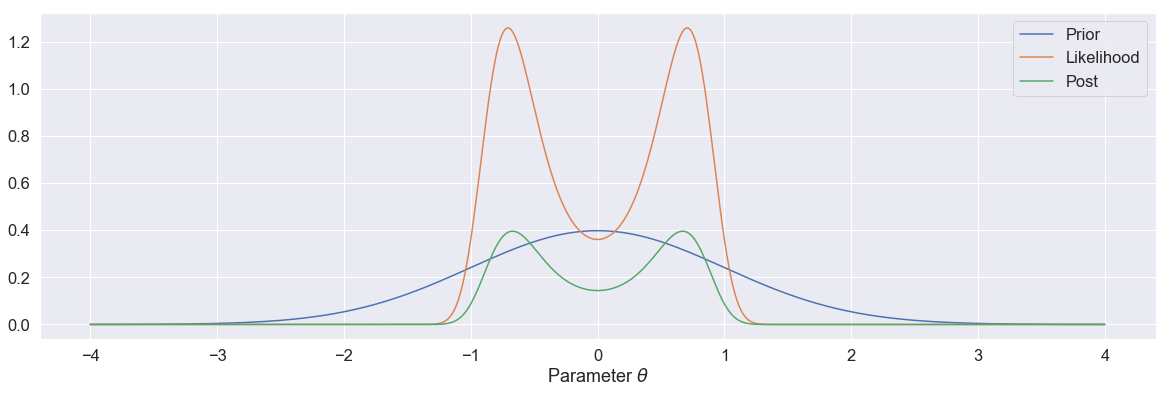

In [9]:
npdf = lambda x, m, v: np.exp(-(x-m)**2/(2*v))/np.sqrt(2*np.pi*v)

sigma2 = 0.1
thetas = np.linspace(-4, 4, 500)

prior = lambda x: npdf(x, 0, 1)
lik = lambda x: npdf(0.5, x**2, sigma2) # f(theta) - Is it just arbitrary to create the spikes? + why 0.5 
post_scaled = lambda x: prior(x)*lik(x)

plt.figure(figsize=(20, 6))
plt.plot(thetas, prior(thetas), label='Prior')
plt.plot(thetas, lik(thetas), label='Likelihood')
plt.plot(thetas, post_scaled(thetas), label='Post')
plt.xlabel('Parameter $\\theta$')
plt.legend()

In [10]:
quad(prior, a=-10, b=10), quad(lik, a=-10, b=10), quad(post_scaled, a=-10, b=10)

((1.0000000000000002, 8.671029888166837e-10),
 (1.5963089175944187, 3.052606330808606e-11),
 (0.522771669162562, 3.970051917301293e-09))

In [18]:
true_theta = 0.707
y = true_theta**2 + np.random.normal(loc=0, scale=sigma2, size=100)

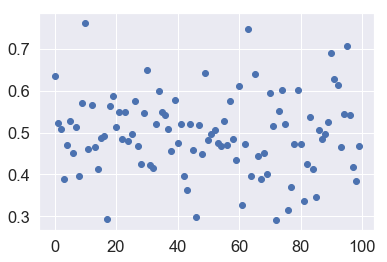

In [19]:
plt.figure()
plt.plot(y, 'o')
plt.show()

### Model 2

In 1D we can test the framework ability to represent variuous non-Gaussian distributions, but we cannot test how well it can represent couplings or dependencies in the exact posterior. Therefore, let's go to 2D.

Suppose we have a model with a 2D parameter vector $\theta \in \mathbb{R}^2$. Let's impose an improper uniform prior

$$\theta_i \sim \mathcal{U}$$

and as likelihood, we can consider 

$$p(y|\theta) = f(\theta) = 0.5\mathcal{N}(\theta|\mu_1, S) + 0.5\mathcal{N}(\theta|\mu_1, S)$$

Then the posterior we would proportional to

$$p(\theta|y) = \frac{p(y|\theta)p(\theta)}{p(y)} \propto 0.5\mathcal{N}(\theta|\mu_1, S) + 0.5\mathcal{N}(\theta|\mu_1, S)$$

That is, this is similar to the bivariate normal example in the Bishop book.


In [23]:
from scipy.stats import multivariate_normal as mvn

In [25]:
math.exp(2)

7.38905609893065

Text(0, 0.5, 'Theta 2')

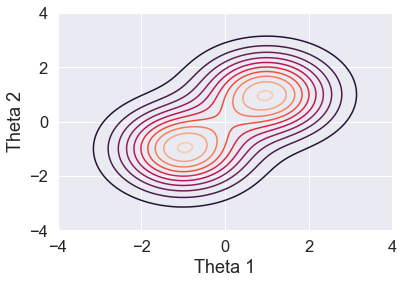

In [22]:
mu1 = np.array([-1, -1])
mu2 = np.array([1, 1])
S = np.identity(2)
p = 0.5


X, Y = np.meshgrid(thetas, thetas)
Z = np.column_stack((X.ravel(), Y.ravel()))

pdf = (1-p)*mvn.pdf(Z, mu1, S) + p*mvn.pdf(Z, mu2, S)

plt.contour(thetas, thetas, pdf.reshape((len(thetas), len(thetas))), 10)
plt.xlabel('Theta 1')
plt.ylabel('Theta 2')


### Model 3: The eight school model

This is more realistic model, but still sufficiently simple for us to understand the problems. This model is also known to produce "funnel" shapes posterior distributions and therefore it is an interesting test case for normalizing flows. That is, the shape of the posterior is more complex than a Gaussian, but not simpler that the highly multimodal posteriors of neural networks for example.

Suppose, we want to compare data from students from $J$ different schools. For each school we have collected exam results and summarized the performance of the students such that $y_j$ is the mean performance of the $j$'th school with corresponding standard deviation $\sigma_j$. 

We want to compare the results for the $J$ schools using a hierarchical model.

First, we assume that the data from each school can be modelled as:

$$y_{j} \sim \mathcal{N}(\theta_j, \sigma_j^2),$$

where $\theta_j$ is the "underlying true level" of the $j$'th school. Next, we assume that all the "school levels" come from a common distribution:

$$\theta_i \sim \mathcal{N}(\mu, \tau)$$

and since we don't know the parameters for this distribution, we assign priors to them as well:

$$\mu \sim \mathcal{N}(0, 5)$$

$$\tau \sim \text{half-Cauchy}(0, 5)$$





### Model 4: Something more complicated?